In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.stats as ss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import shap
import lime
import lime.lime_tabular

In [119]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.utils import resample


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

import IPython
from IPython.display import display, HTML

IPython.core.display.display = display
IPython.core.display.HTML    = HTML

RANDOM_SEED = 2080
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [3]:
df = pd.read_csv("../data/icu_train.csv")
df_test = pd.read_csv("../data/icu_test.csv")
print(df.shape)

(73370, 141)


In [4]:
X_train = df.drop(columns=["hospital_death"])
y_train = df["hospital_death"].astype(int)
X_test = df_test.drop(columns=["hospital_death"])
y_test = df_test["hospital_death"].astype(int)

In [5]:
def evaluate(name, y_true, y_prob, threshold = .5):
    y_pred = (y_prob >= threshold).astype(int)

    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, average='binary')
    f1_w = f1_score(y_true, y_pred, average='weighted')

    print(f"\n=== {name} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"AUROC : {auc:.4f}")
    print(f"Precision : {prec:.4f}")
    print(f"Recall : {rec:.4f}")
    print(f"F1 : {f1:.4f}")
    print(f"F1_weighted : {f1_w:.4f}")
    print("-" * 40)

    return {"model": name, "acc": acc, "auc": auc, "prec": prec, "rec": rec, "f1": f1, "f1_weighted": f1_w}

def plot_metric(results, metric='f1'):
    df = pd.DataFrame(results)
    
    df['run'] = df.groupby('model').cumcount() + 1
    df['label'] = df['model'] + ' #' + df['run'].astype(str)
    
    count = len(df)
    width = max(8, count * 0.4)
    _, ax = plt.subplots(figsize=(width, 6))
    
    ax.bar(df['label'], df[metric])
    ax.set_ylabel(metric.upper() + ' Score')
    ax.set_title(f'{metric.upper()} Score by Model and Run')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

classes = np.unique(y_train)
cw = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, cw))
sample_weight_train = np.array([class_weight_dict[y] for y in y_train])

results = []

## Logistic Regression

In [6]:
X = X_train.copy()
y = y_train.copy()
X_majority = X[y == 0]
y_majority = y[y == 0]
X_minority = X[y == 1]
y_minority = y[y == 1]

X_majority_down, y_majority_down = resample(
    X_majority, y_majority,
    replace=False,
    n_samples=len(y_minority),
    random_state=RANDOM_SEED)

X_bal = pd.concat([X_minority, X_majority_down], axis=0)
y_bal = pd.concat([y_minority, y_majority_down], axis=0)

perm = np.random.RandomState(RANDOM_SEED).permutation(len(y_bal))
X_bal = X_bal.iloc[perm].reset_index(drop=True)
y_bal = y_bal.iloc[perm].reset_index(drop=True)

print("Balanced training set class counts:")
print(y_bal.value_counts())


log_clf_bal = LogisticRegression(
    max_iter=3000,
    penalty="l2",
    solver="lbfgs",
    n_jobs=-1,
    random_state=RANDOM_SEED)
log_clf_bal.fit(X_bal, y_bal)

y_pred_bal = log_clf_bal.predict(X_test)
y_prob_lr = log_clf_bal.predict_proba(X_test)[:, 1]
print("=== Downsampled Logistic Regression ===")
print(classification_report(y_test, y_pred_bal, digits=4))

results.append(evaluate("Logistic Regression", y_test, y_pred_bal))

Balanced training set class counts:
hospital_death
0    6332
1    6332
Name: count, dtype: int64
=== Downsampled Logistic Regression ===
              precision    recall  f1-score   support

           0     0.9742    0.8032    0.8805     16760
           1     0.2712    0.7751    0.4018      1583

    accuracy                         0.8008     18343
   macro avg     0.6227    0.7892    0.6411     18343
weighted avg     0.9136    0.8008    0.8392     18343


=== Logistic Regression ===
Accuracy : 0.8008
AUROC : 0.7892
Precision : 0.2712
Recall : 0.7751
F1 : 0.4018
F1_weighted : 0.8392
----------------------------------------


## XGBoost 

In [7]:
param_dist = {
    'n_estimators': [100,200,400,800],
    'learning_rate': [0.01,0.03,0.1],
    'max_depth': [3,5,7],
    'subsample': [0.6,0.8,1.0],
    'colsample_bytree': [0.6,0.8,1.0],
}

xgb = XGBClassifier(objective='binary:logistic', eval_metric='auc', random_state=42)
search_xgb = RandomizedSearchCV(
    xgb, param_distributions=param_dist,
    n_iter=30, cv=4, scoring='roc_auc',
    random_state=2080, n_jobs=1, verbose=1
)

search_xgb.fit(X_bal, y_bal)
print("Best XGB params:", search_xgb.best_params_)
xgb_clf = search_xgb.best_estimator_


Fitting 4 folds for each of 30 candidates, totalling 120 fits
Best XGB params: {'subsample': 0.6, 'n_estimators': 400, 'max_depth': 7, 'learning_rate': 0.03, 'colsample_bytree': 1.0}


In [8]:
xgb_clf.fit(X_bal, y_bal, verbose=False)
y_prob_xgb = xgb_clf.predict_proba(X_test)[:, 1]
y_pred_xgb = xgb_clf.predict(X_test)


results.append(evaluate("XGBoost", y_test, y_prob_xgb))


=== XGBoost ===
Accuracy : 0.8062
AUROC : 0.8916
Precision : 0.2828
Recall : 0.8105
F1 : 0.4193
F1_weighted : 0.8436
----------------------------------------


## MLP

In [9]:
input_dim = X_bal.shape[1]

mlp = Sequential([
    Dense(512, activation="relu", input_dim=input_dim),
    BatchNormalization(),
    Dropout(0.1),
    Dense(256, activation="relu"),
    BatchNormalization(),
    Dropout(0.1),
    Dense(128, activation="relu"),
    BatchNormalization(),
    Dropout(0.1),
    Dense(64, activation="relu"),
    BatchNormalization(),
    Dropout(0.1),
    Dense(1, activation="sigmoid")])

mlp.summary()



/Users/ioanacristescu/Desktop/icu-dp/venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │        72,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 248,577 (971.00 KB)

 Trainable params: 246,657 (963.50 KB)

 Non-trainable params: 1,920 (7.50 KB)

In [10]:
# Plot train and validation loss and acccuracy over epochs

In [11]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = "binary_crossentropy"
metrics = [tf.keras.metrics.AUC(name="auc"), tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.BinaryAccuracy(name="accuracy")
]

mlp.compile(optimizer=optimizer, loss=loss, metrics=metrics)

early_stop = EarlyStopping(monitor="val_auc",mode="max",patience=30,restore_best_weights=True,verbose=1)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_auc',
    mode='max',
    factor=0.5,         
    patience=2,         
    min_lr=1e-5,        
    verbose=1
)

history = mlp.fit(X_bal,y_bal, epochs=100, batch_size=64, validation_split=0.15,
    #callbacks=[early_stop, lr_scheduler],
    class_weight=class_weight_dict,verbose=2)

y_prob_mlp = mlp.predict(X_test, verbose=0).ravel()
y_pred_mlp = (y_prob_mlp >= 0.5).astype(int)


results.append(evaluate("TensorFlow MLP", y_test, y_prob_mlp))

Epoch 1/100
169/169 - 1s - 8ms/step - accuracy: 0.7094 - auc: 0.8059 - loss: 1.0762 - precision: 0.6495 - recall: 0.9161 - val_accuracy: 0.6295 - val_auc: 0.8541 - val_loss: 0.7607 - val_precision: 0.5680 - val_recall: 0.9913
Epoch 2/100
169/169 - 0s - 2ms/step - accuracy: 0.7012 - auc: 0.8667 - loss: 0.6498 - precision: 0.6301 - recall: 0.9821 - val_accuracy: 0.6574 - val_auc: 0.8603 - val_loss: 0.7743 - val_precision: 0.5891 - val_recall: 0.9740
Epoch 3/100
169/169 - 0s - 2ms/step - accuracy: 0.7167 - auc: 0.8924 - loss: 0.5483 - precision: 0.6411 - recall: 0.9911 - val_accuracy: 0.6911 - val_auc: 0.8692 - val_loss: 0.7552 - val_precision: 0.6152 - val_recall: 0.9718
Epoch 4/100
169/169 - 0s - 2ms/step - accuracy: 0.7381 - auc: 0.9095 - loss: 0.5009 - precision: 0.6588 - recall: 0.9933 - val_accuracy: 0.7089 - val_auc: 0.8699 - val_loss: 0.7243 - val_precision: 0.6344 - val_recall: 0.9458
Epoch 5/100
169/169 - 0s - 2ms/step - accuracy: 0.7530 - auc: 0.9191 - loss: 0.4743 - precision:

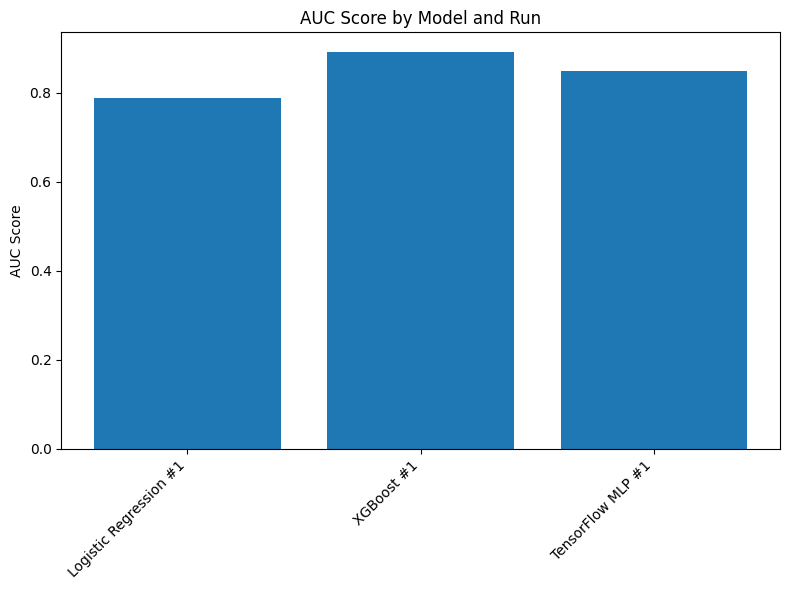

In [12]:
plot_metric(results, metric='auc')
# Other metrics are in the output above. The names don't exactly map, though, because I'm difficult. 
#"model": name, "acc": acc, "auc": auc, "prec": prec, "rec": rec, "f1": f1, "f1_weighted": f1_w}

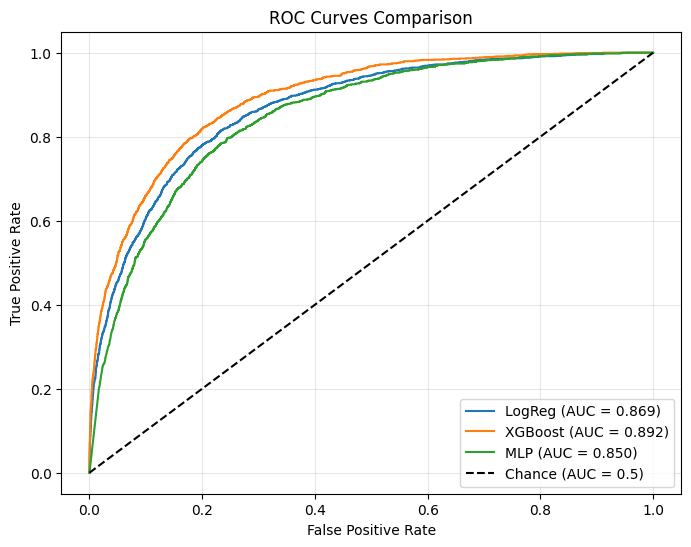

In [13]:
fpr_lr,  tpr_lr,  _ = roc_curve(y_test, y_prob_lr)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_prob_mlp)

auc_lr  = auc(fpr_lr,  tpr_lr)
auc_xgb = auc(fpr_xgb, tpr_xgb)
auc_mlp = auc(fpr_mlp, tpr_mlp)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr,  tpr_lr,  label=f'LogReg (AUC = {auc_lr:.3f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.3f})')
plt.plot(fpr_mlp, tpr_mlp, label=f'MLP (AUC = {auc_mlp:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.5)')

plt.title('ROC Curves Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)


In [ ]:
eth_cols = ['ethnicity_Asian', 'ethnicity_Caucasian', 'ethnicity_Hispanic', 'ethnicity_Native American', 'ethnicity_Other/Unknown']

def decode_onehot(df, cols, prefix):
    def pick(row):
        ones = [c for c in cols if row[c] == 1]
        if len(ones) == 1:
            return ones[0].split(prefix,1)[1]
        else:
            return 'Unknown'
    return df.apply(pick, axis=1)

df_test = df_test.copy()
df_test['ethnicity_cat'] = decode_onehot(df_test, eth_cols, 'ethnicity_')

hosp_cols = [c for c in df_test.columns if c.startswith('hospital_admit_source_')]

df_test['hosp_admit_src_cat'] = decode_onehot(df_test, hosp_cols, 'hospital_admit_source_')

df_test['age_group'] = pd.qcut(df_test['age'], q=[0, 0.33, 0.66, 1.0], labels=['young','mid','old'])

demo_axes = {
    'gender' : df_test['gender'].unique(),
    'ethnicity_cat' : df_test['ethnicity_cat'].unique(),
    'hosp_admit_src_cat': df_test['hosp_admit_src_cat'].unique(),
    'age_group' : ['young','mid','old']}

models = [
    ('LogReg', y_pred_bal,  y_prob_lr),
    ('XGBoost', y_pred_xgb, y_prob_xgb),
    ('MLP', y_pred_mlp, y_prob_mlp),]


for axis in ['gender','ethnicity_cat','hosp_admit_src_cat','age_group']:
    counts = df_test[axis].value_counts().sort_index()
    prevalence = df_test.groupby(axis)['hospital_death'].mean().loc[counts.index]
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
    counts.plot.bar(ax=ax1); ax1.set_title(f'{axis} counts'); ax1.set_xlabel(axis); ax1.set_ylabel('n samples')
    prevalence.plot.bar(ax=ax2); ax2.set_title(f'{axis} positive rate'); ax2.set_xlabel(axis); ax2.set_ylabel('hospital_death rate')

In [ ]:
records = []
for model_name, y_pred, y_prob in models:
    for axis, groups in demo_axes.items():
        for grp in groups:
            mask = df_test[axis] == grp
            if mask.sum() < 30:
                continue
            yt = y_test[mask]
            yp = y_pred[mask]
            yp_prob = y_prob[mask]

            records.append({
                'model' : model_name,
                'demographic': axis,
                'group': grp,
                'n_samples': int(mask.sum()),
                'accuracy': accuracy_score(yt, yp),
                'auc': roc_auc_score(yt, yp_prob) if yt.nunique()>1 else float('nan'),
                'precision': precision_score(yt, yp, zero_division=0),
                'recall': recall_score(yt, yp, zero_division=0),
                'f1': f1_score(yt, yp, zero_division=0)})

df_subgroup = pd.DataFrame(records)

table = df_subgroup.pivot_table(index=['demographic','group'], columns='model', values=['accuracy','auc','f1'], aggfunc='first')

print(table)

In [ ]:
# Rename TF-MLP t MLP
# Plot accuracy as well (not just balanced accuracy)

In [ ]:
y_prob_lr  = log_clf_bal.predict_proba(X_test)[:,1]; y_pred_lr  = (y_prob_lr >= 0.5).astype(int)
y_prob_xgb = xgb_clf.predict_proba(X_test)[:,1]; y_pred_xgb = (y_prob_xgb >= 0.5).astype(int)
y_prob_mlp = mlp.predict(X_test).ravel();    y_pred_mlp = (y_prob_mlp >= 0.5).astype(int)

demographics = ['gender','ethnicity_cat','hosp_admit_src_cat','age_group']
models = [('LogReg',  y_pred_lr), ('XGBoost', y_pred_xgb), ('TF-MLP',  y_pred_mlp)]

records = []
for name, y_pred in models:
    for axis in demographics:
        for grp in df_test[axis].unique():
            mask = df_test[axis] == grp
            if mask.sum() < 30: 
                continue
            ba = balanced_accuracy_score(y_test[mask], y_pred[mask])
            records.append({'model': name, 'demographic': axis,'group': grp,
                'balanced_accuracy': ba, 'n_samples': mask.sum(), 'prevalence': df_test.loc[mask,'hospital_death'].mean()})
df_bal = pd.DataFrame(records)

for axis in demographics:
    df_axis = df_bal[df_bal['demographic']==axis]
    groups = list(df_axis['group'].unique())
    x = np.arange(len(groups))
    width = 0.25

    fig, (ax_ba, ax_count, ax_prev) = plt.subplots(1,3,figsize=(len(groups)*0.7+15,4))
    for i,(name,_) in enumerate(models):
        vals = []
        for grp in groups:
            sel = df_axis[(df_axis['model']==name)&(df_axis['group']==grp)]
            vals.append(sel['balanced_accuracy'].iloc[0] if not sel.empty else np.nan)
        ax_ba.bar(x + i*width, vals, width, label=name)
    ax_ba.set_xticks(x + width*(len(models)-1)/2)
    ax_ba.set_xticklabels([str(g) for g in groups], rotation=45, ha='right')
    ax_ba.set_title(f'Balanced Accuracy by {axis}')
    ax_ba.set_ylabel('Balanced Accuracy')
    ax_ba.legend(loc='lower left')

    counts = [ df_axis[df_axis['group']==grp]['n_samples'].iloc[0] for grp in groups ]
    ax_count.bar(x, counts, width)
    ax_count.set_xticks(x); ax_count.set_xticklabels([str(g) for g in groups], rotation=45, ha='right')
    ax_count.set_title('Group Size')
    ax_count.set_ylabel('n samples')

    prevs = [ df_axis[df_axis['group']==grp]['prevalence'].iloc[0] for grp in groups ]
    ax_prev.bar(x, prevs, width)
    ax_prev.set_xticks(x); ax_prev.set_xticklabels([str(g) for g in groups], rotation=45, ha='right')
    ax_prev.set_title('Outcome Prevalence')
    ax_prev.set_ylabel('Death Rate')

In [ ]:
import pandas as pd
from sklearn.inspection import permutation_importance

# 1) Logistic Regression: top-10 by absolute coefficient
log_coefs = pd.Series(log_clf_bal.coef_.ravel(), index=X_train.columns)
top10_log = log_coefs.abs().sort_values(ascending=False).head(10)
print("=== Top 10 Logistic Regression Coefficients (abs) ===")
print(top10_log.to_string(), "\n")

# 2) XGBoost: top-10 by built-in importance
xgb_imp = pd.Series(xgb_clf.feature_importances_, index=X_train.columns)
top10_xgb = xgb_imp.sort_values(ascending=False).head(10)
print("=== Top 10 XGBoost Feature Importances ===")
print(top10_xgb.to_string(), "\n")

In [ ]:
y_prob_mlp = mlp.predict(X_test).ravel()
baseline_auc = roc_auc_score(y_test, y_prob_mlp)

importances = {}
for col in X_test.columns:
    X_perm = X_test.copy()
    X_perm[col] = np.random.permutation(X_perm[col].values)
    y_prob_perm = mlp.predict(X_perm).ravel()
    perm_auc = roc_auc_score(y_test, y_prob_perm)
    importances[col] = baseline_auc - perm_auc

imp = pd.Series(importances).sort_values(ascending=False)
print("Top 10 MLP features (manual permutation importance):")
print(imp.head(10).to_string())


## SHAP

### Logistic Regression

In [53]:
# Changed from LinearExplainer to KernelExplainer
# KernelExplainer -> valid post-processing method for DP

In [97]:
# Initialize the explainer with the logistic regression
# X_shap = X_train.astype(np.float64)
# explainer = shap.LinearExplainer(log_clf_bal, X_shap)
# shap_values = explainer.shap_values(X_shap)

def model_predict(X):
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X, columns=X_train.columns)
    return log_clf_bal.predict_proba(X)[:, 1]

background = shap.sample(X_train, 50, random_state=2080)
explainer = shap.KernelExplainer(model_predict, background)
X_test_small = shap.sample(X_test, 1000, random_state=2080)
shap_values = explainer.shap_values(X_test_small, nsamples=200)

  0%|          | 0/4000 [00:00<?, ?it/s]

/var/folders/wp/t4hgc9nx4s90xpch3k5c7kqr0000gn/T/ipykernel_71752/3338003245.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_small)


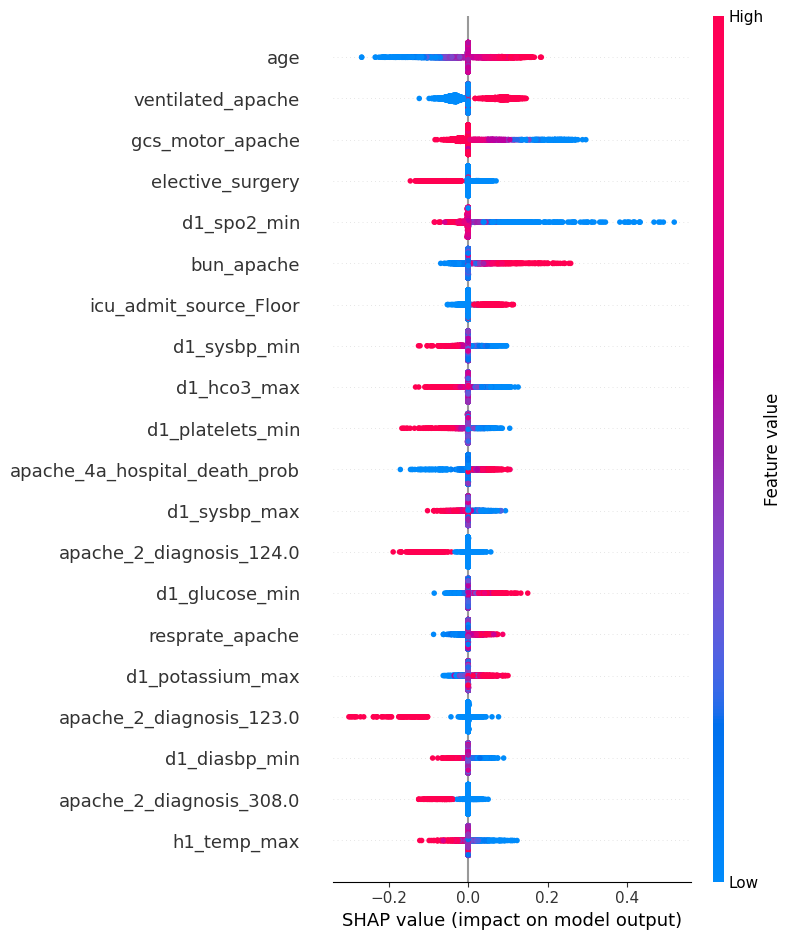

In [98]:
# Beeswarm (features sorted by importance)
shap.summary_plot(shap_values, X_test_small)

/var/folders/wp/t4hgc9nx4s90xpch3k5c7kqr0000gn/T/ipykernel_71752/2002056050.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, plot_type='bar', feature_names = X_train.columns)


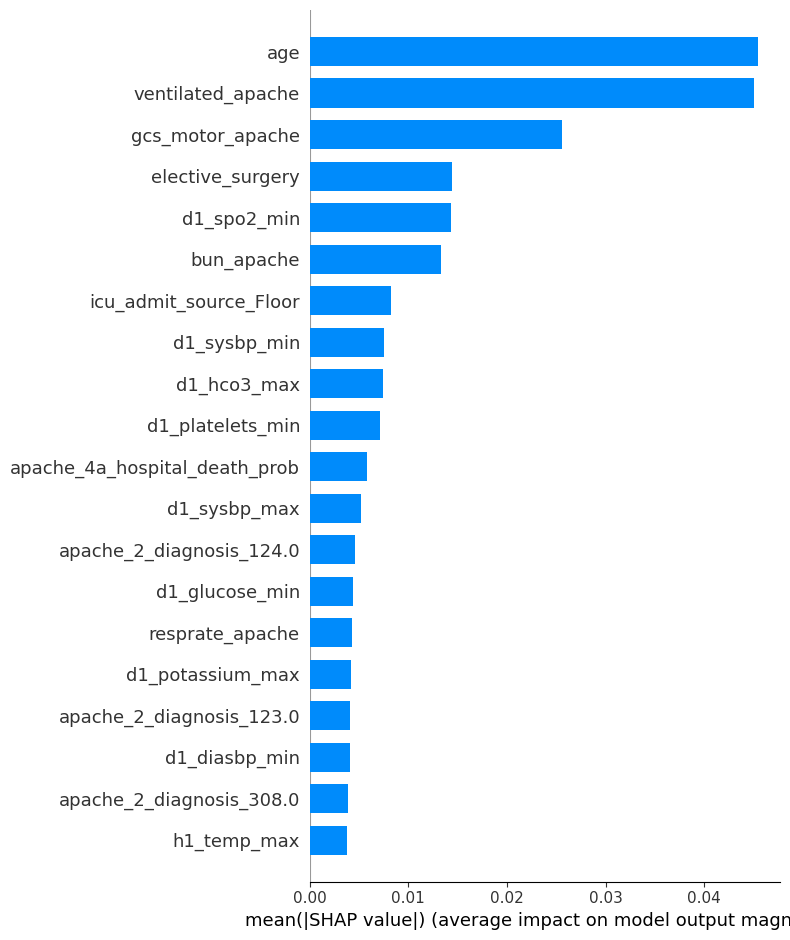

In [99]:
# Bar (mean absolute value per feature)
shap.summary_plot(shap_values, plot_type='bar', feature_names = X_train.columns)

In [100]:
explainer.expected_value

0.2898632797696069

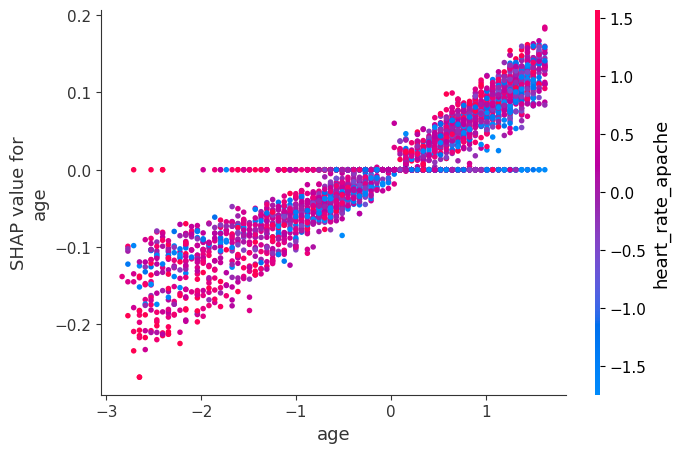

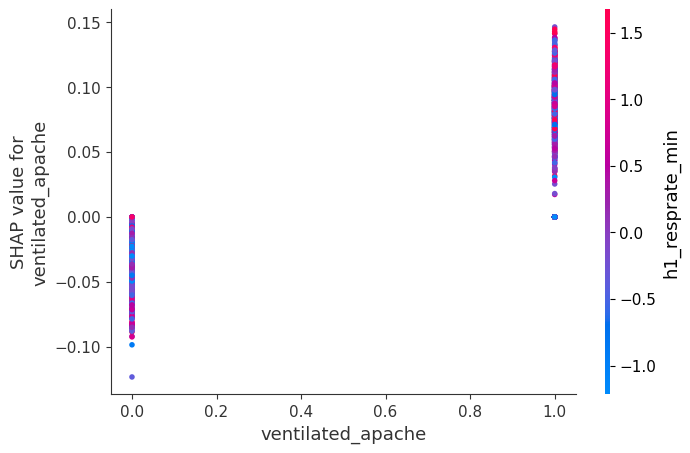

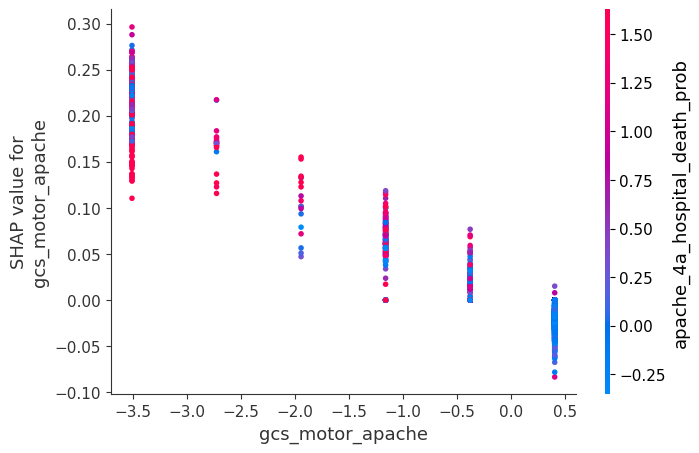

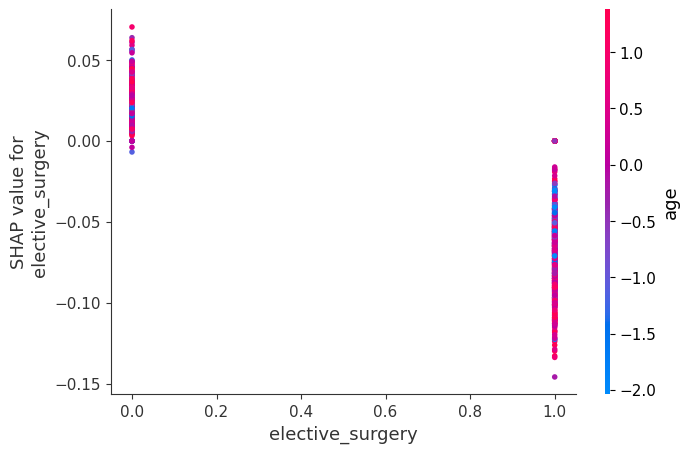

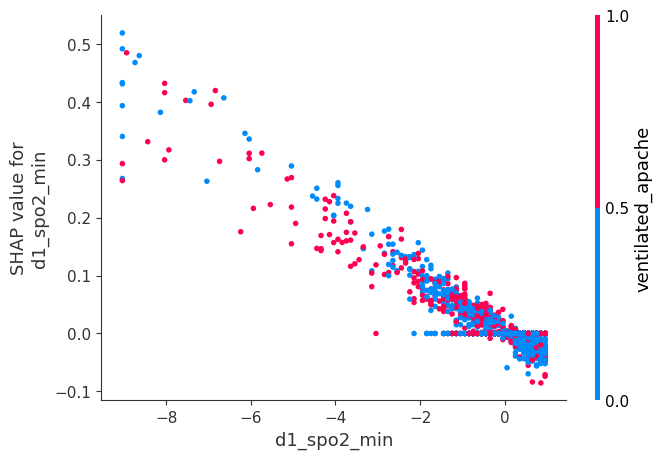

In [101]:
# Dependence plots 
# One per feature. Shows how that feature’s value vs. its SHAP effect, colored by a second feature.
# # Sort features by importance
mean_abs_shap = np.abs(shap_values).mean(axis=0)
top_idx = np.argsort(mean_abs_shap)[::-1]  
top_features = X_train.columns[top_idx[:5]] 
for feat in top_features:
    shap.dependence_plot(feat, shap_values, X_test_small)

# # 4. Dependence Plot (Feature vs. Impact)
# raw_shap_values = shap_values.values.astype(np.float64)
# mean_abs_shap = np.abs(raw_shap_values).mean(axis=0)

# # Sort features by importance
# top_idx = np.argsort(mean_abs_shap)[::-1]  # descending order
# top_features = X_train.columns[top_idx[:5]] 

# # Now this will work:
# for feat in top_features:
#     print(f"\n🔍 Dependence plot for: {feat}")
#     shap.dependence_plot(feat, raw_shap_values, X_train)

  0%|          | 0/100 [00:00<?, ?it/s]

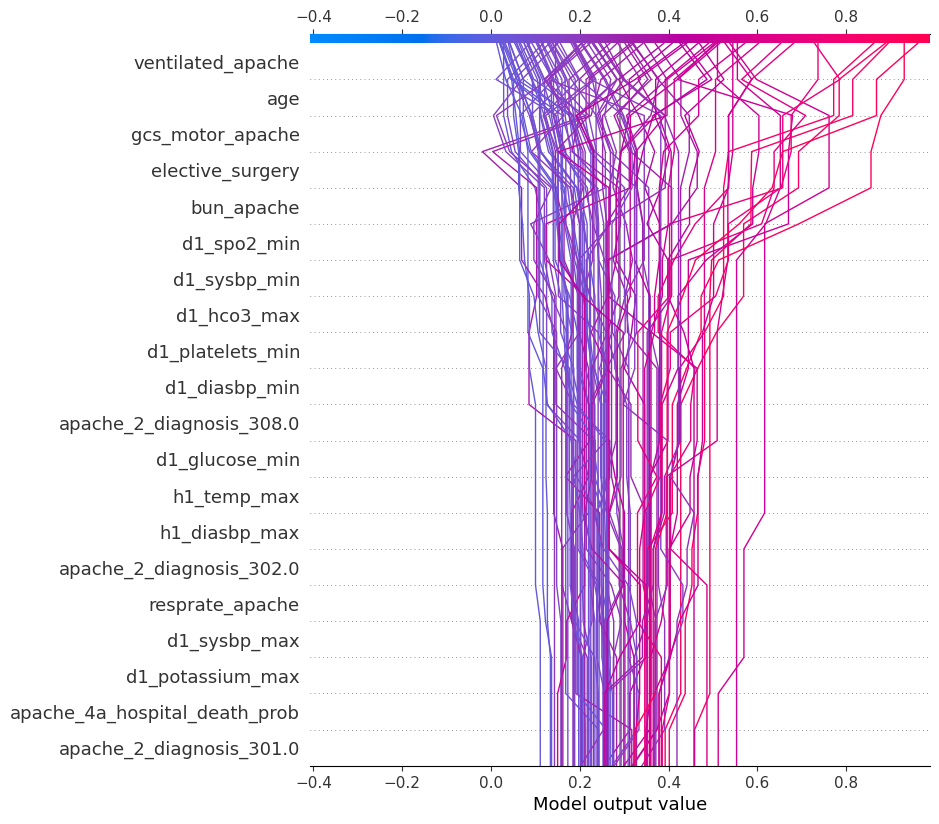

In [102]:
# Decision plot 
# Tracks cumulative impact of features for each sample
# pick 50 random test rows
X_small = shap.sample(X_test_small, 100, random_state=2080)

shap_exp = explainer(X_small)
shap.decision_plot(
    explainer.expected_value,
    shap_exp.values,
    X_small,
    ignore_warnings=True     
)

### XGBoost

In [77]:
def predict_fn(X):
    if not hasattr(X, "columns"):
        X = pd.DataFrame(X, columns=X_train.columns)
    return xgb_clf.predict_proba(X)[:, 1]

# ensure every column is float64
background = background.astype(np.float64)
X_test_small = X_test_small.astype(np.float64)

# Use the same background as above
explainer2 = shap.TreeExplainer(xgb_clf, background)

# Use the same X_test_small as above
shap_values2 = explainer2.shap_values(X_test_small, nsamples=200)

 99%|===================| 3953/4000 [00:41<00:00]        

In [78]:
# Initialize the explainer with the XGBoost model
# X_shap = X_train.astype(np.float64)
# explainer2 = shap.Explainer(xgb_clf, X_shap)
# shap_values2 = explainer2.shap_values(X_shap)

/var/folders/wp/t4hgc9nx4s90xpch3k5c7kqr0000gn/T/ipykernel_71752/1035318981.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values2, X_test_small)


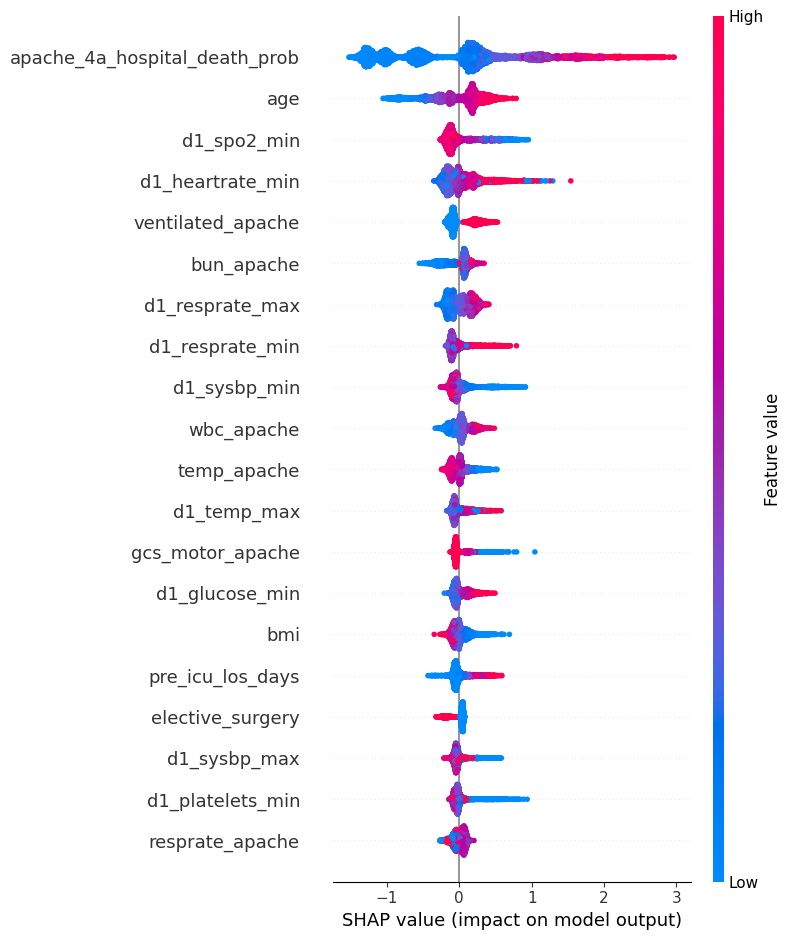

In [79]:
# Beeswarm (features sorted by importance)
shap.summary_plot(shap_values2, X_test_small)

/var/folders/wp/t4hgc9nx4s90xpch3k5c7kqr0000gn/T/ipykernel_71752/789285579.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values2, plot_type='bar', feature_names = X_train.columns)


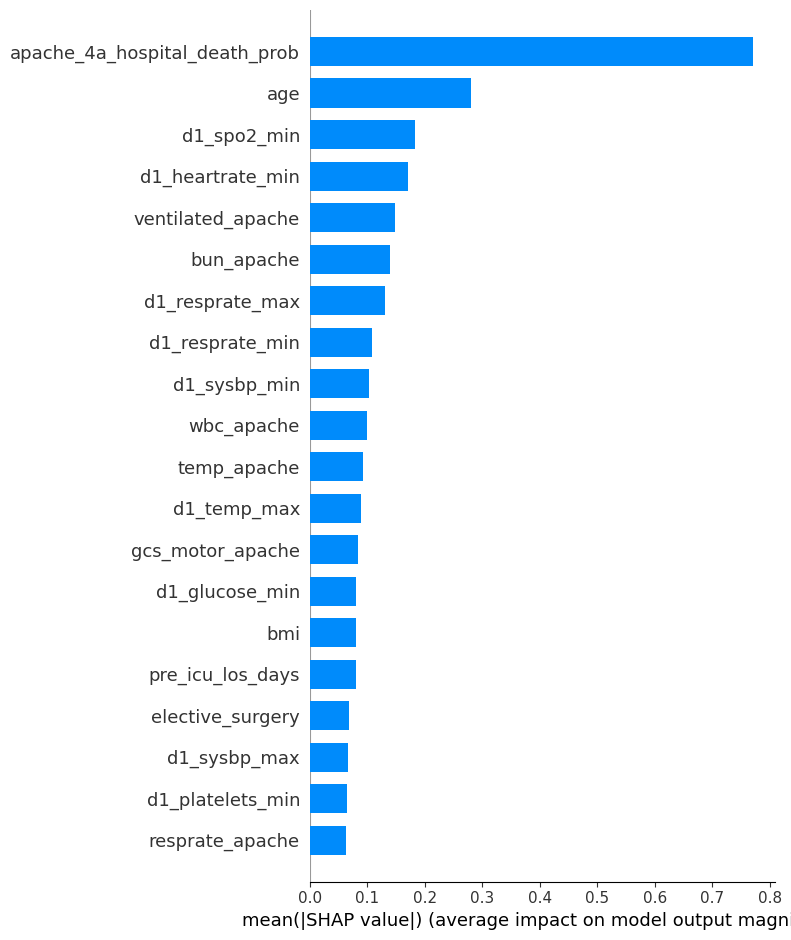

In [80]:
# Bar (mean absolute value per feature)
shap.summary_plot(shap_values2, plot_type='bar', feature_names = X_train.columns)

In [81]:
explainer2.expected_value

np.float64(-1.4416877103917658)

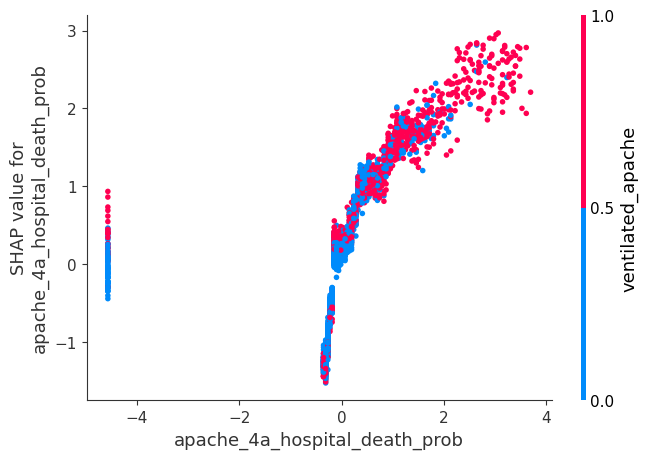

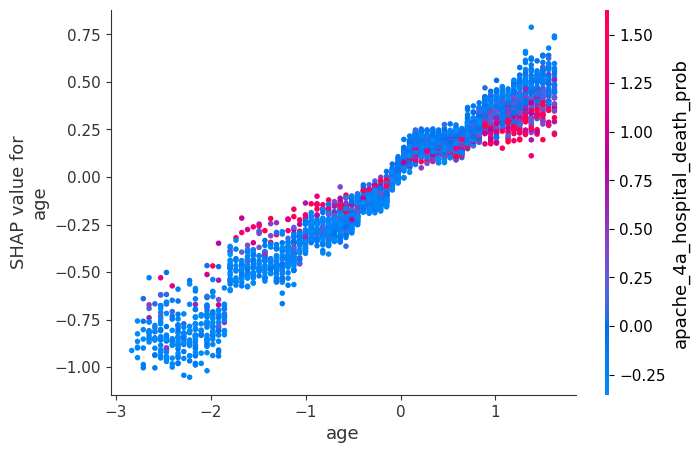

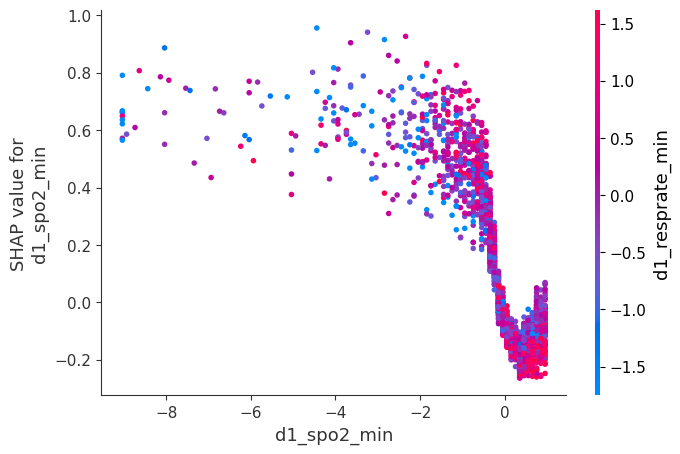

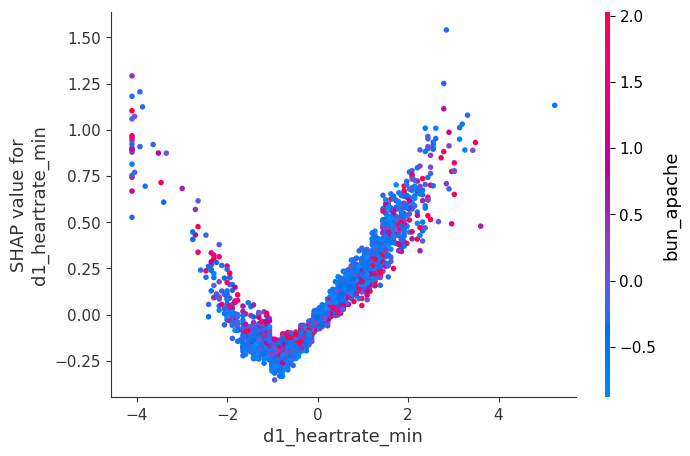

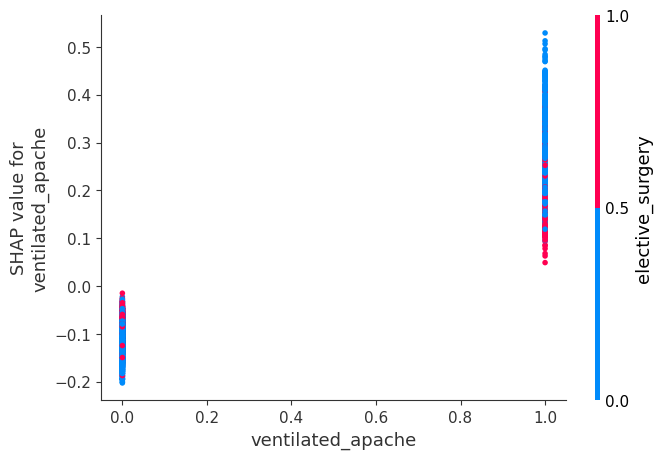

In [83]:
# Dependence plots 
# One per feature. Shows how that feature’s value vs. its SHAP effect, colored by a second feature.
# # Sort features by importance
mean_abs_shap2 = np.abs(shap_values2).mean(axis=0)
top_idx2 = np.argsort(mean_abs_shap2)[::-1]  
top_features2 = X_train.columns[top_idx2[:5]] 
for feat in top_features2:
    shap.dependence_plot(feat, shap_values2, X_test_small)

# # 4. Dependence Plot (Feature vs. Impact)
# # raw_shap_values2 = shap_values2.values.astype(np.float64)
# mean_abs_shap2 = np.abs(shap_values2).mean(axis=0)

# # Sort features by importance
# top_idx2 = np.argsort(mean_abs_shap2)[::-1]  # descending order
# top_features2 = X_train.columns[top_idx2[:5]] 

# # Now this will work:
# for feat in top_features2:
#     print(f"\n🔍 Dependence plot for: {feat}")
#     shap.dependence_plot(feat, shap_values2, X_shap)

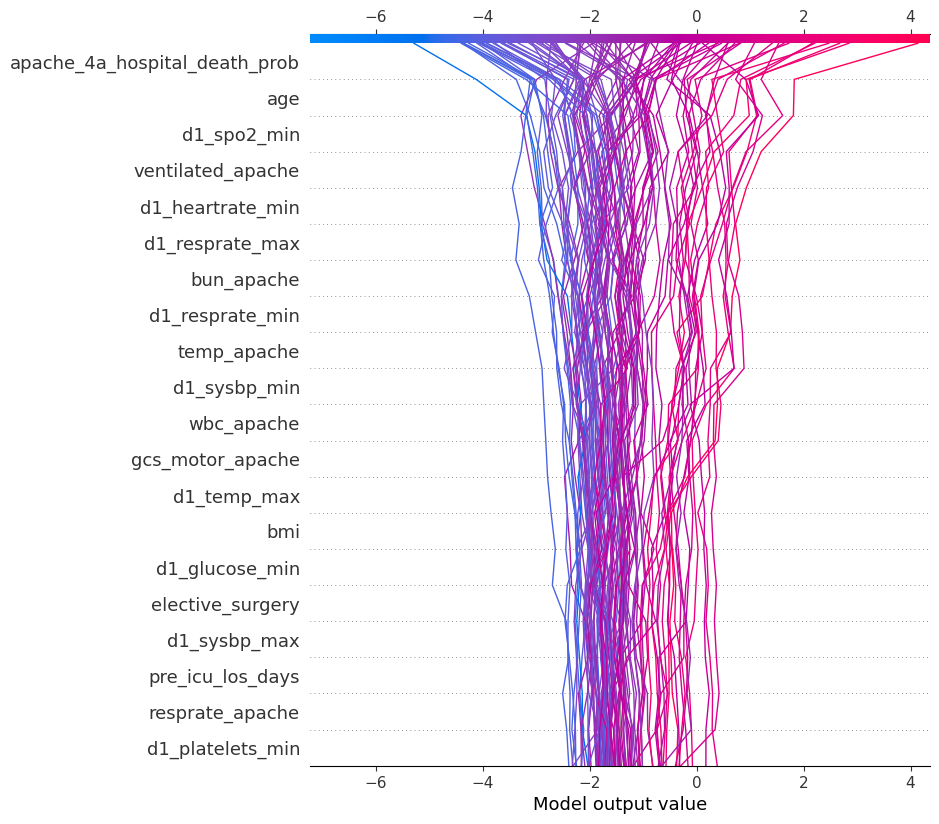

In [85]:
# Decision plot 
# Tracks cumulative impact of features for each sample
# pick 50 random test rows

# use the same X_small as above
shap_exp2 = explainer2(X_small)
shap.decision_plot(
    explainer2.expected_value,
    shap_exp2.values,
    X_small,
    ignore_warnings=True     
)

### MLP

In [106]:
bg_array = background.to_numpy(dtype=float)
test_array = X_test_small.to_numpy(dtype=float)
def predict_fn_mlp(X):
    if not hasattr(X, "columns"):
        X = pd.DataFrame(X, columns=X_train.columns)
    probs = mlp.predict(X)               
   
    if probs.ndim == 2 and probs.shape[1] == 2:
        # softmax: second column is P(class=1)
        return probs[:, 1]
    elif probs.ndim == 2 and probs.shape[1] == 1:
        # sigmoid: single-column output is P(class=1)
        return probs[:, 0]

# Use the same background as above
explainer3 = shap.KernelExplainer(predict_fn_mlp, bg_array)

# Use the same X_test_small as above
shap_values3 = explainer3.shap_values(test_array, nsamples=200)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


  0%|          | 0/4000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 381us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 385us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 390us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 380us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
3

/var/folders/wp/t4hgc9nx4s90xpch3k5c7kqr0000gn/T/ipykernel_71752/4200873073.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values3, X_test_small)


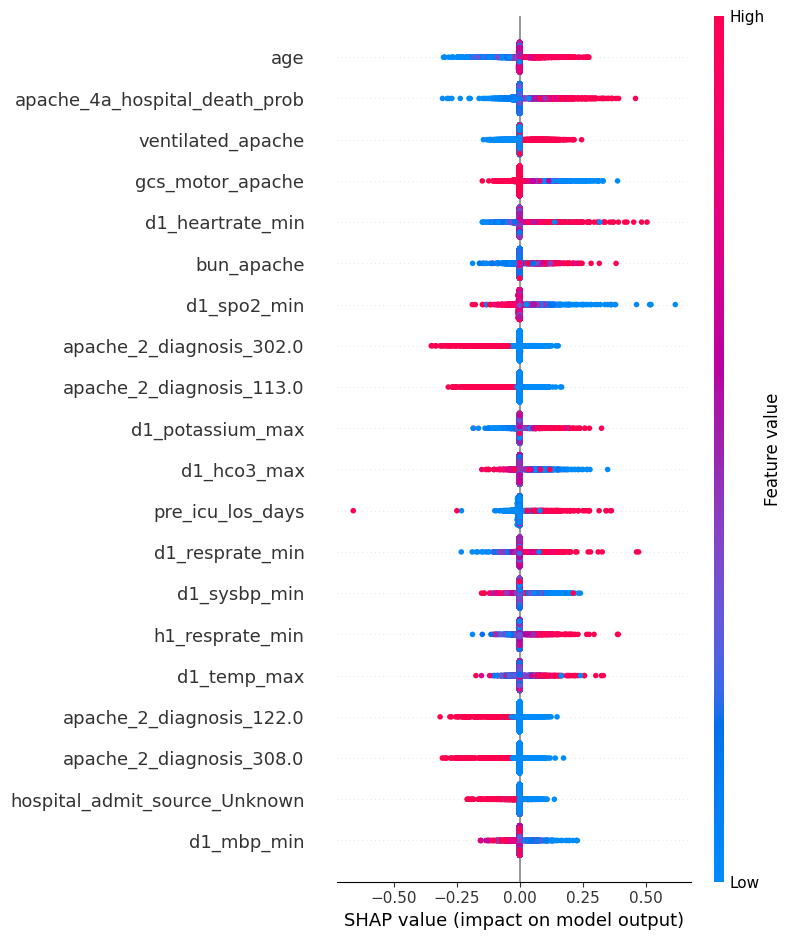

In [110]:
# Beeswarm (features sorted by importance)
shap.summary_plot(shap_values3, X_test_small)

/var/folders/wp/t4hgc9nx4s90xpch3k5c7kqr0000gn/T/ipykernel_71752/3610037109.py:2: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values3, plot_type='bar', feature_names = X_train.columns)


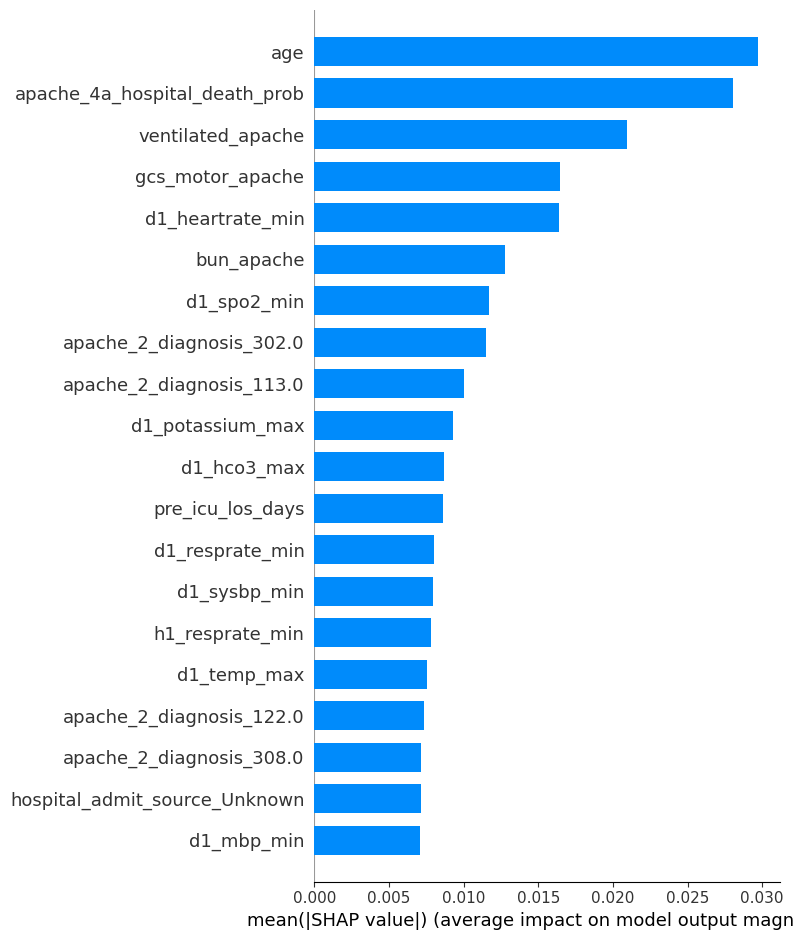

In [108]:
# Bar (mean absolute value per feature)
shap.summary_plot(shap_values3, plot_type='bar', feature_names = X_train.columns)

In [111]:
explainer3.expected_value

0.24833105613750575

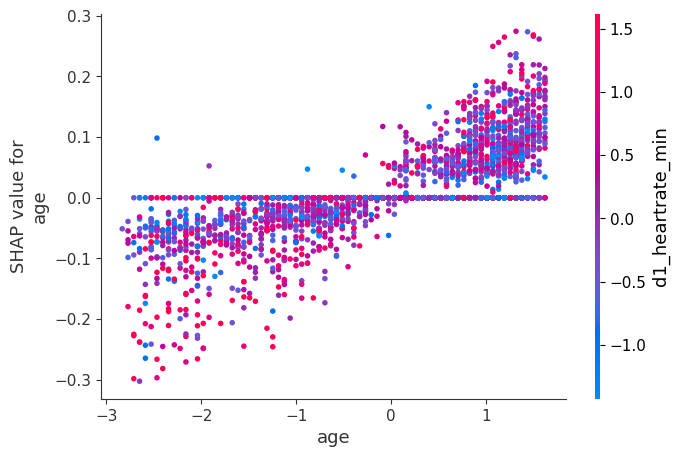

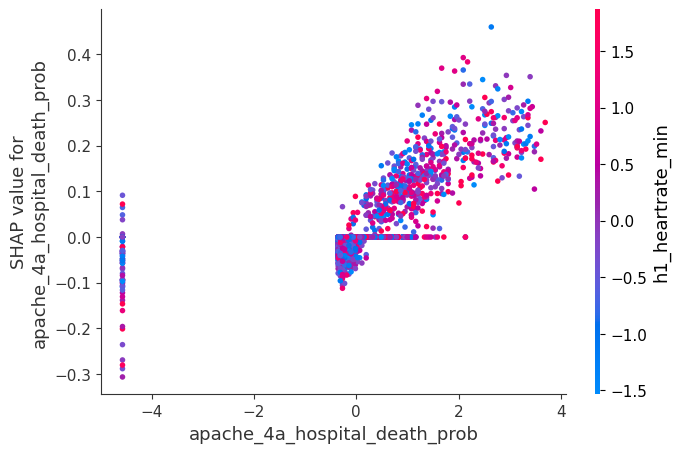

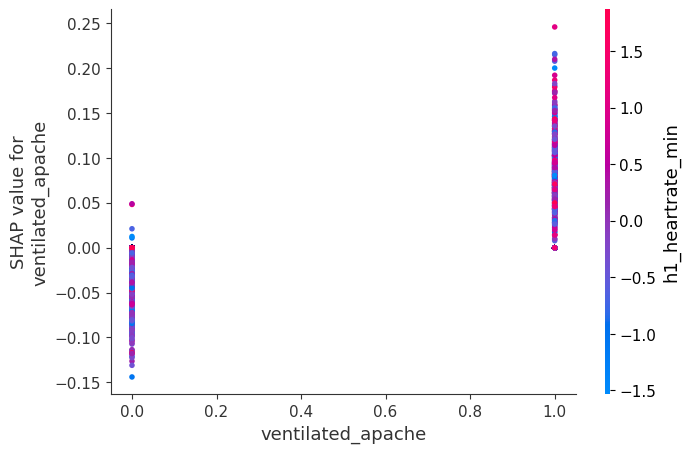

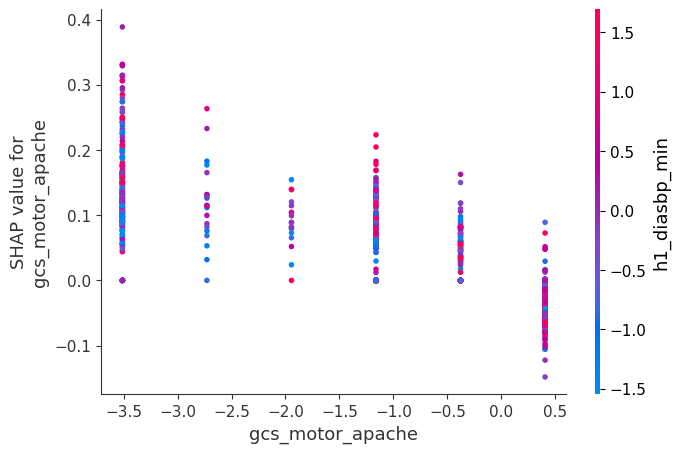

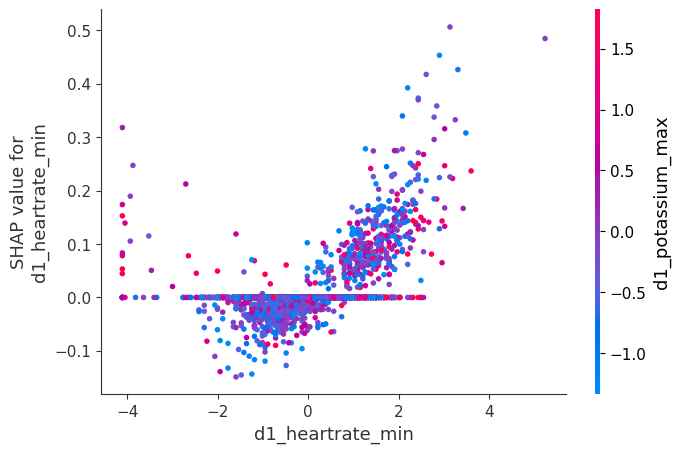

In [112]:
# Dependence plots 
# One per feature. Shows how that feature’s value vs. its SHAP effect, colored by a second feature.
# # Sort features by importance
mean_abs_shap3 = np.abs(shap_values3).mean(axis=0)
top_idx3 = np.argsort(mean_abs_shap3)[::-1]  
top_features3 = X_train.columns[top_idx3[:5]] 
for feat in top_features3:
    shap.dependence_plot(feat, shap_values3, X_test_small)

  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
3522/3522 ━━━━━━━━━━━━━━━━━━━━ 1s 359us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
3525/3525 ━━━━━━━━━━━━━━━━━━━━ 1s 353us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
3525/3525 ━━━━━━━━━━━━━━━━━━━━ 1s 353us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
3525/3525 ━━━━━━━━━━━━━━━━━━━━ 1s 363us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
3522/3522 ━━━━━━━━━━━━━━━━━━━━ 1s 364us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
3525/3525 ━━━━━━━━━━━━━━━━━━━━ 1s 353us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
3522/3522 ━━━━━━━━━━━━━━━━━━━━ 1s 359us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
3522/3522 ━━━━━━━━━━━━━━━━━━━━ 1s 353us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
3522/3522 ━━━━━━━━━━━━━━━━━━━━ 1s 354us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
3522/3522 ━━━━━━━━━━━━━━━━━━━━ 1s 356us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
3525/3525 ━━━━━━━━━━━━━━━━━━━━ 1s 354us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
3522/3522 ━━━━━━━━━━━━━━━━━━━━ 1s 357us/step
1/1 ━━━━━━━━━━━

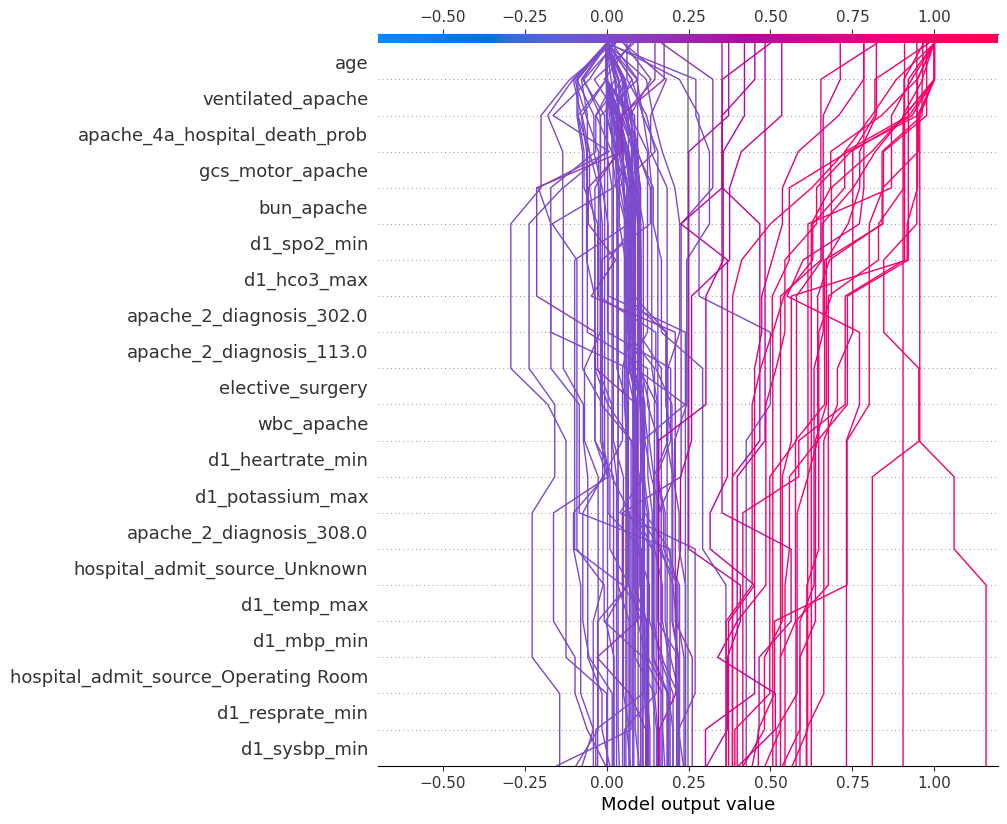

In [117]:
# Decision plot 
# Tracks cumulative impact of features for each sample
# pick 50 random test rows

# use the same X_small as above
X_small_arr = X_small.astype(np.float64).to_numpy()
shap_exp3 = explainer3(X_small_arr)
shap.decision_plot(
    explainer3.expected_value,
    shap_exp3.values,
    X_small,
    ignore_warnings=True     
)

## LIME

### Linear Regression

In [131]:
rng = np.random.RandomState(42)

explainer_l = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns.tolist(),
    class_names=['Class 0', 'Class 1'],
    mode='classification',
    random_state = rng
)

# Explain a prediction (e.g., the 5th sample)
i = 5
exp = explainer_l.explain_instance(X_test.iloc[i].values, log_clf_bal.predict_proba, num_features=10)
exp.show_in_notebook(show_all=False)

/Users/ioanacristescu/Desktop/icu-dp/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [121]:
exp.save_to_file('lime_explanation.html')

### XGBoost

In [130]:
explainer_l2 = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns.tolist(),
    class_names=['Class 0', 'Class 1'],
    mode='classification',
    random_state  = rng
)

# Explain a prediction (e.g., the 5th sample)
i = 5
exp = explainer_l2.explain_instance(X_test.iloc[i].values, xgb_clf.predict_proba, num_features=10)
exp.show_in_notebook(show_all=False)

In [123]:
exp.save_to_file('lime_explanation2.html')

### MLP

In [127]:
def predict_fn_mlp_proba(X):
    # reattach columns if needed
    if not hasattr(X, "columns"):
        X = pd.DataFrame(X, columns=X_train.columns)
    # get the raw model output
    probs = mlp.predict(X)            # shape (n,1) or (n,)
    probs = np.array(probs).reshape(-1)  # make sure it’s (n,)
    # build two-column [P(class=0), P(class=1)]
    p1 = probs
    p0 = 1.0 - p1
    return np.vstack([p0, p1]).T 

In [128]:
explainer_l3 = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns.tolist(),
    class_names=['Class 0', 'Class 1'],
    mode='classification',
    random_state  = rng
)

# Explain a prediction (e.g., the 5th sample)
i = 5
exp = explainer_l3.explain_instance(X_test.iloc[i].values, predict_fn_mlp_proba, num_features=10)
exp.show_in_notebook(show_all=False)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 407us/step


In [129]:
exp.save_to_file('lime_explanation3.html')